In [2]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv, read_excel, DataFrame
from skimage.feature import hessian_matrix_det as Hessian
from skimage.feature import local_binary_pattern as LBP
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
p = os.path.join('../../','raw','CookIRCamET','Images','CookTests','HiRes')
p2 = os.path.join('../../','work','CookIRCamET','Images','CookTests','HiRes')
n_feat = 12
n_components = 4

In [3]:
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

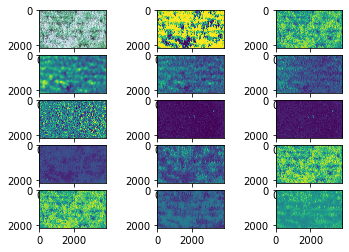

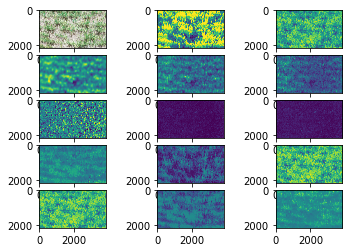

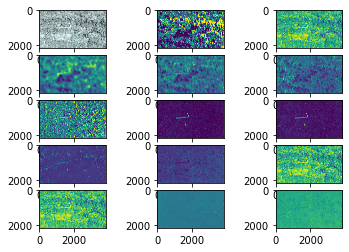

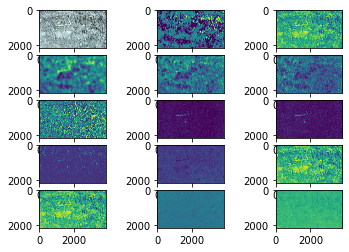

In [4]:
f_imgs=[]
test_imgs=[]
train_imgs=[]
for f in os.listdir(p):
    if 'bgr' in f:
        f_imgs = np.append(f_imgs,f)
        bgr = cv2.imread(os.path.join(p,f),cv2.IMREAD_UNCHANGED)
        f_labels = f.split('_bgr')[0]+'_labels.tif'
        labels = cv2.imread(os.path.join(p,f_labels),cv2.IMREAD_UNCHANGED)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        plt.subplot(531)
        plt.imshow(bgr)
        plt.subplot(532)
        plt.imshow(labels)
        l,a,bb = cv2.split(lab)
        h,s,v = cv2.split(hsv)
        sd1 = localSD(img, 127)
        sd2 = localSD(img, 63)
        sd3 = localSD(img, 31)
        lbp1 = LBP(img, 32, 4, method='ror')
        lbp2 = LBP(img, 24, 3, method='ror')
        lbp3 = LBP(img, 16, 2, method='ror')
        plt.subplot(533)
        plt.imshow(img)
        plt.subplot(534)
        plt.imshow(sd1)
        plt.subplot(535)
        plt.imshow(sd2)
        plt.subplot(536)
        plt.imshow(sd3)
        plt.subplot(537)
        plt.imshow(lbp1)
        plt.subplot(538)
        plt.imshow(lbp2)
        plt.subplot(539)
        plt.imshow(lbp3)
        plt.subplot(5,3,10)
        plt.imshow(h)
        plt.subplot(5,3,11)
        plt.imshow(s)
        plt.subplot(5,3,12)
        plt.imshow(v)
        plt.subplot(5,3,13)
        plt.imshow(l)
        plt.subplot(5,3,14)
        plt.imshow(a)
        plt.subplot(5,3,15)
        plt.imshow(bb)
        plt.show()
        img_size = l.shape
        bb = bb.ravel()
        a = a.ravel()
        l = l.ravel()
        h = h.ravel()
        s = s.ravel()
        v = v.ravel()
        sd1 = sd1.ravel()
        sd2 = sd2.ravel()
        sd3 = sd3.ravel()
        lbp1 = lbp1.ravel()
        lbp2 = lbp2.ravel()
        lbp3 = lbp3.ravel()
        feat = np.vstack((l.T,a.T,bb.T,h.T,s.T,v.T,sd1.T,sd2.T,sd3.T,lbp1.T,lbp2.T,lbp3.T)).T
        #labels = np.sum(np.vstack((soil.ravel().T, residue.ravel().T*2, shadow.ravel().T*3, vegetation.ravel().T*4)).T,axis=1)
        labels = labels.ravel()
        if f.split('_')[0]=='20220509152045' or f.split('_')[0]=='20220509152630':
            train_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})
        else:
            test_imgs.append({'bgr':bgr,'feats':feat,'labels':labels})

In [5]:
train_feats = []
train_labels = []
for sample in train_imgs:
    train_feats.append(sample['feats'])
    train_labels.append(sample['labels'])

In [6]:
test_feats = []
test_labels = []
for sample in test_imgs:
    test_feats.append(sample['feats'])
    test_labels.append(sample['labels'])

In [7]:
train_feats = np.array(train_feats).reshape((-1,n_feat)).astype(np.float32)
train_labels = np.array(train_labels).reshape((-1,1)).astype(np.int32).ravel()
test_feats = np.array(test_feats).reshape((-1,n_feat)).astype(np.float32)
test_labels = np.array(test_labels).reshape((-1,1)).astype(np.int32).ravel()

In [8]:
scaler = StandardScaler()
train_feats = scaler.fit_transform(train_feats)

In [9]:
#need feature selection her
svc = svm.SVC()
clf_svc = RFECV(svc,step=1, cv=5,n_jobs=-1)
clf_svc.fit(train_feats, train_labels)
clf_svc.ranking_

KeyboardInterrupt: 

In [ ]:
parameters = {'C':np.logspace(-3,3,7), 'gamma':np.logspace(-4,0,5),'decision_function_shape':('ovo', 'ovr')}
svc = svm.SVC()
clf_svc = GridSearchCV(svc, parameters,n_jobs=-1,cv=5)
clf_svc.fit(train_feats, train_labels)
clf_svc.best_params_
model_svc = clf_svc.best_estimator_
test_feats = scaler.transform(test_feats)
pred_svc = model_svc.predict(test_feats)

In [ ]:
def cornfusion(obs,pred,nclass):
    M = np.zeros((nclass,nclass))
    for i in range(obs.shape[0]):
        o = obs[i]
        p = pred[i]
        M[o,p] = M[o,p]+1
    return M

In [ ]:
M_svc = cornfusion(test_labels,pred_svc,n_components)
M_svc = M_rfc/np.sum(M_svc,axis=1).reshape((-1,1))

In [ ]:
M_svc